In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sacc
from scipy.stats import chi2
from scipy.special import erfinv

In [2]:
nEbins = 3 # Number of energy bins
nzbins = 6 # Number of redshift bins
ncls = 7 # Number of cls per power spectra
sacc_path = 'xCell_output/real_data2/output/cls_cov.fits' # File containing xCell power spectra data
combEbins = True # Whether to combine redshift bins for each energy bin

In [3]:
# Loads in data, only keeps first 7 data points to match previous calculations
s = sacc.Sacc.load_fits(sacc_path)
s.remove_selection(ell__gt=352)

In [4]:
# Finds relevant indices in sacc object
indices = []
for i in range(nEbins):
    indices.append([])
    for j in range(nzbins):
        ind_here = s.indices('cl_00', (f'IceCube__{i}', f'LOWZ__{j}'))
        if combEbins:
            indices[i] += list(ind_here)
        else:
            indices[i].append(list(ind_here))
indices = np.array(indices)

# Gets ells, cls, covs, and inverse covs
ells, _ = s.get_ell_cl('cl_00', 'IceCube__0', 'LOWZ__0')
cov_total = s.covariance.covmat
if combEbins:
    cls = np.array([s.mean[ind] for ind in indices])
    covs = np.array([cov_total[ind][:, ind] for ind in indices])
    icovs = np.array([np.linalg.inv(cov) for cov in covs])
else:
    cls = []
    covs = []
    icovs = []
    for i in range(nEbins):
        cls.append([])
        covs.append([])
        icovs.append([])
        for j in range(nzbins):
            ind = indices[i,j]
            cls[i].append(s.mean[ind])
            covs[i].append(cov_total[ind][:, ind])
            icovs[i].append(np.linalg.inv(covs[i][j]))
    cls = np.array(cls)
    covs = np.array(covs)
    icovs = np.array(icovs)     

In [5]:
# Calculates chi2
chi2vals = []
for i in range(nEbins):
    if combEbins:
        chi2vals.append(np.dot(cls[i], np.dot(icovs[i], cls[i])))
    else:
        chi2vals.append([])
        for j in range(nzbins):
            chi2vals[i].append(np.dot(cls[i][j], np.dot(icovs[i][j], cls[i][j])))
print(chi2vals)

[29.356239164545723, 29.57432637424045, 42.78872904218106]


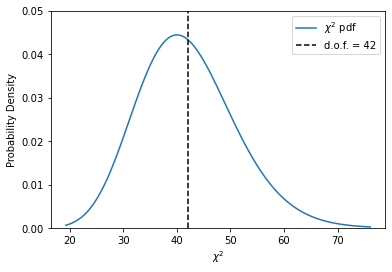

In [6]:
# Plots chi2 distribution for dof = 42
plot_dof = 42
x = np.linspace(chi2.ppf(0.001, plot_dof),
                chi2.ppf(0.999, plot_dof), 100)
plt.plot(x, chi2.pdf(x, plot_dof), label='$\chi^2$ pdf')
plt.axvline(plot_dof, ls='--', c='k', label=f'd.o.f. = {plot_dof}')
plt.xlabel('$\chi^2$')
plt.ylabel('Probability Density')
plt.ylim(0,0.05)
plt.legend()

#plt.savefig('Chi2Dist.pdf')

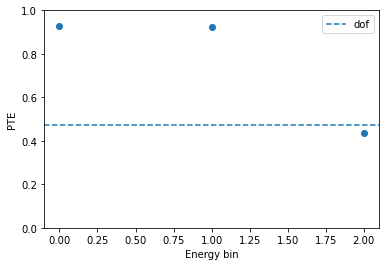

In [7]:
# Calculates pte and SNR
dof = ncls
if combEbins:
    dof *= nzbins
    
pte = []
SNR = []
for i in range(nEbins):
    if combEbins:
        pte.append(1-chi2.cdf(chi2vals[i], dof))
        expc_frac_inside = 1-2*pte[i]
        sigma = np.sqrt(2)*erfinv(expc_frac_inside)
        SNR.append(sigma)
    else:
        pte.append([])
        SNR.append([])
        for j in range(nzbins):
            pte[i].append(1-chi2.cdf(chi2vals[i][j], dof))
            expc_frac_inside = 1-2*pte[i][j]
            sigma = np.sqrt(2)*erfinv(expc_frac_inside)
            SNR[i].append(sigma)

# Display PTEs
plt.scatter(np.arange(len(np.array(pte).flatten())), np.array(pte).flatten())
plt.ylim(0,1)
if combEbins:
    plt.xlabel('Energy bin')
else:
    plt.xlabel('Arbitrary units')
plt.ylabel('PTE')
plt.axhline(1-chi2.cdf(dof, dof), linestyle='--', label='dof')
plt.legend()

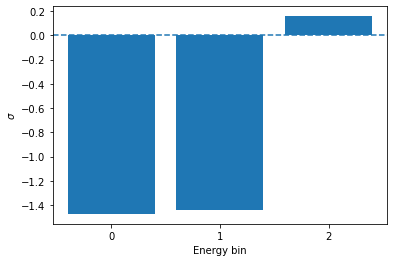

In [8]:
# Display SNRs
plt.bar(np.arange(len(np.array(SNR).flatten())), np.array(SNR).flatten())
if combEbins:
    plt.xlabel('Energy bin')
    plt.xticks(np.arange(nEbins), labels=np.arange(nEbins))
else:
    plt.xlabel('Arbitrary units')
plt.ylabel('$\sigma$')
plt.axhline(0, linestyle='--')
#plt.savefig(f'SNRcalcsCombE{combEbins}.pdf')